# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.5.4-iota.75.77.125.126.130.133.137.140.143'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (2019), https://ec.europa.eu/
GADM (2019), https://public.opendatasoft.com/
Geloky (2019), https://geloky.com/
I

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (2019), https://ec.europa.eu/
GADM (2019), https://public.opendatasoft.com/
Geloky (2019), https://geloky.com/
I

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
160579,2020-07-21,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160580,2020-07-22,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160581,2020-07-23,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160582,2020-07-24,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160583,2020-07-25,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
160579,2020-07-21,Colombia,Vichada,2,1,0,1
160580,2020-07-22,Colombia,Vichada,2,1,0,1
160581,2020-07-23,Colombia,Vichada,2,1,0,1
160582,2020-07-24,Colombia,Vichada,2,1,0,1
160583,2020-07-25,Colombia,Vichada,2,1,0,1


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
188,2020-07-21,9816,2177,327,7312
189,2020-07-22,10054,2214,327,7513
190,2020-07-23,10420,2326,327,7767
191,2020-07-24,10680,2501,327,7852
192,2020-07-25,10975,2734,327,7914


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-21,14926765,5908501,617517,8400747,0.020685,0.281399,0.068474
2020-07-22,15209516,6006229,624415,8578872,0.020527,0.282023,0.067847
2020-07-23,15487837,6107207,634179,8746451,0.020473,0.282365,0.067605
2020-07-24,15706992,6092097,640050,8974845,0.020375,0.285696,0.066569
2020-07-25,15707912,6092693,640053,8975166,0.020374,0.285689,0.066567


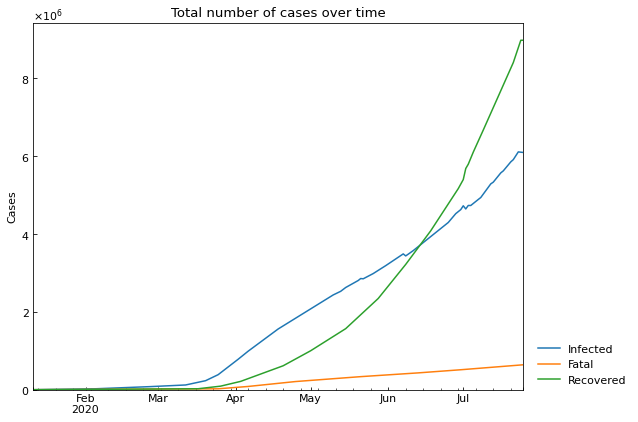

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
192,2020-07-21,26421,5284,988,20149
193,2020-07-22,27216,5582,989,20645
194,2020-07-23,28197,6177,991,21029
195,2020-07-24,28965,6650,994,21321
196,2020-07-25,29724,7168,996,21560


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
160,2020-07-20,25096,4354,985,19757
161,2020-07-21,25736,4593,988,20155
162,2020-07-22,26303,4663,989,20651
163,2020-07-23,27029,5004,990,21035
164,2020-07-24,27956,5636,992,21328


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
160579,2020-07-21,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160580,2020-07-22,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160581,2020-07-23,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160582,2020-07-24,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160583,2020-07-25,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
157491,COL,Colombia,Vichada,2020-07-21,107808
157492,COL,Colombia,Vichada,2020-07-22,107808
157493,COL,Colombia,Vichada,2020-07-23,107808
157494,COL,Colombia,Vichada,2020-07-24,107808
157495,COL,Colombia,Vichada,2020-07-25,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
160579,2020-07-21,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160580,2020-07-22,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160581,2020-07-23,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160582,2020-07-24,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
160583,2020-07-25,2,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
160579,2020-07-21,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
160580,2020-07-22,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
160581,2020-07-23,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
160582,2020-07-24,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
160583,2020-07-25,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
192,2020-07-21,1,0,1,0,0,0,0,3,2,2,1,24.07
193,2020-07-22,1,0,1,0,0,0,0,3,2,2,1,24.07
194,2020-07-23,1,0,1,0,0,0,0,3,2,2,1,24.07
195,2020-07-24,1,0,1,0,0,0,0,3,2,2,1,24.07
196,2020-07-25,1,0,1,0,0,0,0,3,2,2,1,24.07


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
192,2020-07-21,1,0,1,0,0,0,0,3,2,2,1,24.07
193,2020-07-22,1,0,1,0,0,0,0,3,2,2,1,24.07
194,2020-07-23,1,0,1,0,0,0,0,3,2,2,1,24.07
195,2020-07-24,1,0,1,0,0,0,0,3,2,2,1,24.07
196,2020-07-25,1,0,1,0,0,0,0,3,2,2,1,24.07


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

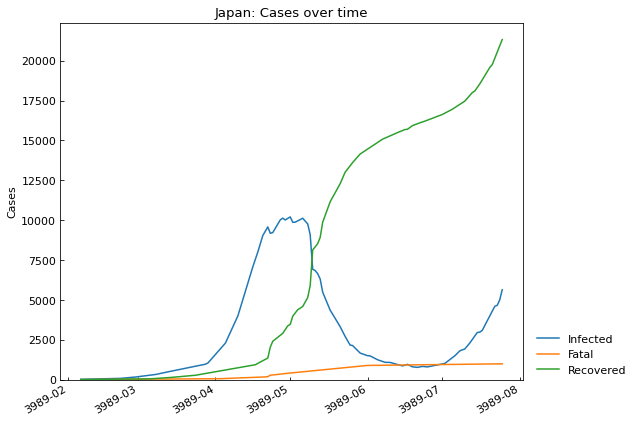

,Date,Confirmed,Infected,Fatal,Recovered
160,2020-07-20,25096,4354,985,19757
161,2020-07-21,25736,4593,988,20155
162,2020-07-22,26303,4663,989,20651
163,2020-07-23,27029,5004,990,21035
164,2020-07-24,27956,5636,992,21328


In [26]:
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

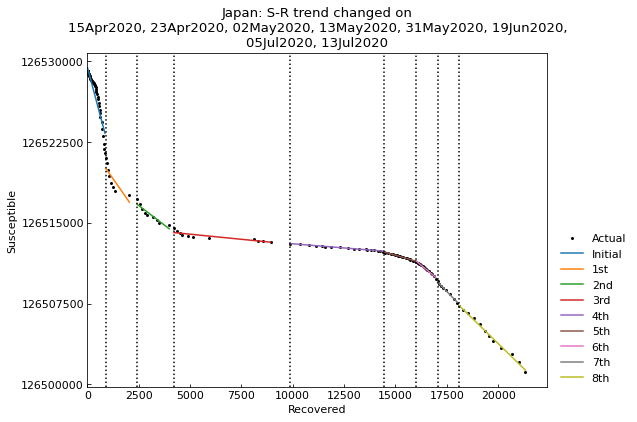

,Type,Start,End,Population
1st,Past,15Apr2020,22Apr2020,126529100
2nd,Past,23Apr2020,01May2020,126529100
3rd,Past,02May2020,12May2020,126529100
4th,Past,13May2020,30May2020,126529100
5th,Past,31May2020,18Jun2020,126529100
6th,Past,19Jun2020,04Jul2020,126529100
7th,Past,05Jul2020,12Jul2020,126529100
8th,Past,13Jul2020,24Jul2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>

Running optimization with 8 CPUs...

	8th phase with SIR-F model finished 154 trials in 0 min 15 sec.

	2nd phase with SIR-F model finished 124 trials in 0 min 15 sec.

	3rd phase with SIR-F model finished 201 trials in 0 min 25 sec.

	4th phase with SIR-F model finished 71 trials in 0 min 10 sec.

	1st phase with SIR-F model finished 498 trials in 1 min 0 sec.

	5th phase with SIR-F model finished 88 trials in 0 min 10 sec.

	6th phase with SIR-F model finished 153 trials in 0 min 15 sec.

	7th phase with SIR-F model finished 105 trials in 0 min 10 sec.

Completed optimization. Total: 2 min 13 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,15Apr2020,22Apr2020,126529100,SIR-F,0.021513,0.002948,0.016839,0.000210,480,6.70,0.017,1585,15,113,0.101736,498,1 min 0 sec
2nd,Past,23Apr2020,01May2020,126529100,SIR-F,0.010991,0.005662,0.056940,0.000109,480,1.80,0.057,3049,30,58,0.038713,124,0 min 15 sec
3rd,Past,02May2020,12May2020,126529100,SIR-F,0.004645,0.013832,0.055332,0.000381,480,0.31,0.055,874,71,24,0.127319,201,0 min 25 sec
4th,Past,13May2020,30May2020,126529100,SIR-F,0.006525,0.032048,0.008200,0.001551,480,0.19,0.008,214,51,10,0.061014,71,0 min 10 sec
5th,Past,31May2020,18Jun2020,126529100,SIR-F,0.015599,0.027960,0.003232,0.000309,480,0.55,0.003,1078,21,11,0.053738,88,0 min 10 sec
6th,Past,19Jun2020,04Jul2020,126529100,SIR-F,0.033725,0.020346,0.155150,0.000094,480,1.39,0.155,3529,9,16,0.102624,153,0 min 15 sec
7th,Past,05Jul2020,12Jul2020,126529100,SIR-F,0.045742,0.021567,0.019212,0.000400,480,2.04,0.019,833,7,15,0.024619,105,0 min 10 sec
8th,Past,13Jul2020,24Jul2020,126529100,SIR-F,0.047118,0.027865,0.007534,0.000400,480,1.65,0.008,833,7,11,0.050474,154,0 min 15 sec


### Accuracy of estimation

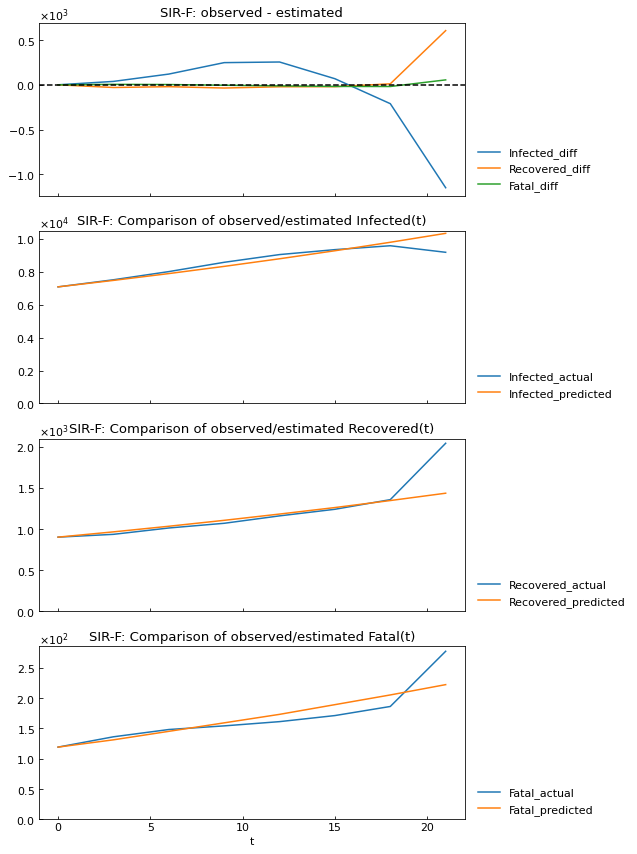

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

0.19

### Show parameter history

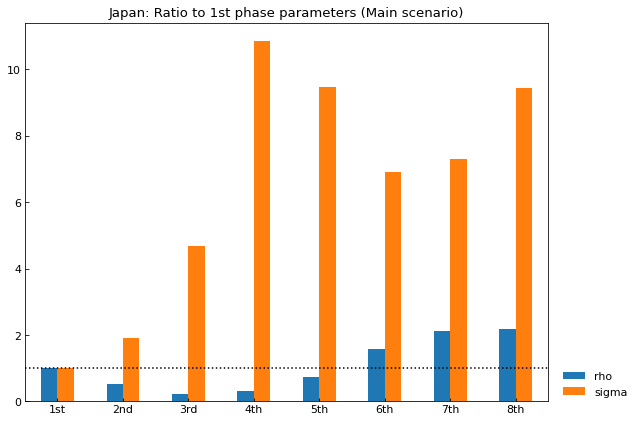

,1st,2nd,3rd,4th,5th,6th,7th,8th
rho,1.0,0.510915,0.215940,0.303291,0.725081,1.567646,2.126247,2.190205
sigma,1.0,1.920638,4.691792,10.870486,9.483850,6.901356,7.315505,9.451730


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

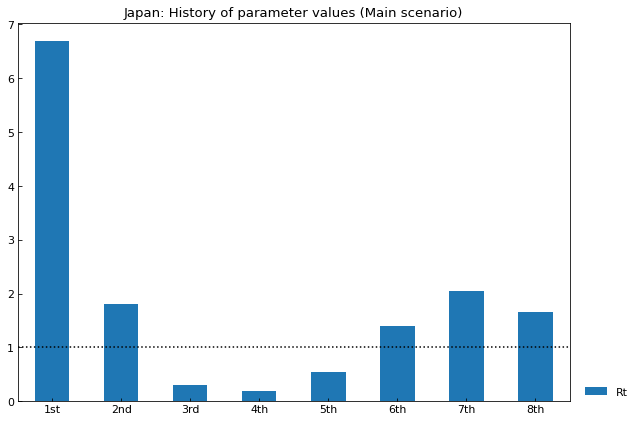

,1st,2nd,3rd,4th,5th,6th,7th,8th
Rt,6.7,1.8,0.31,0.19,0.55,1.39,2.04,1.65


In [33]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

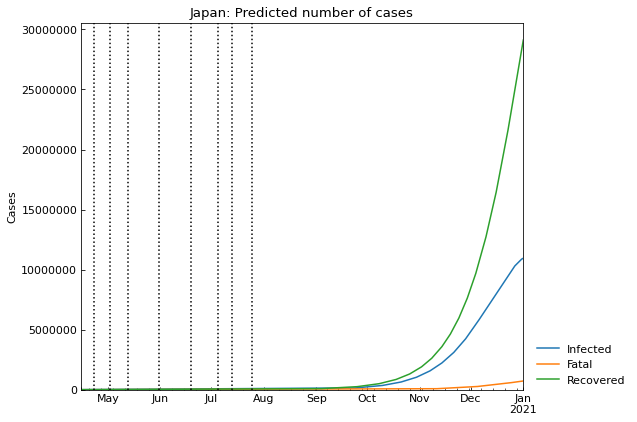

,Date,Fatal,Infected,Recovered,Susceptible
257,28Dec2020,650109,10461381,25832224,89585386
258,29Dec2020,670649,10608481,26713038,88536931
259,30Dec2020,691374,10745185,27605725,87486816
260,31Dec2020,712256,10870952,28509369,86436521
261,01Jan2021,726250,10948900,29117064,85736887


In [34]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [35]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.027865168534541088

In [36]:
sigma_new = sigma_current * 2
sigma_new

0.055730337069082175

In [37]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     0th      Past  15Apr2020  22Apr2020   126529100  SIR-F  0.021513   
         1st      Past  23Apr2020  01May2020   126529100  SIR-F  0.010991   
         2nd      Past  02May2020  12May2020   126529100  SIR-F  0.004645   
         3rd      Past  13May2020  30May2020   126529100  SIR-F  0.006525   
         4th      Past  31May2020  18Jun2020   126529100  SIR-F  0.015599   
         5th      Past  19Jun2020  04Jul2020   126529100  SIR-F  0.033725   
         6th      Past  05Jul2020  12Jul2020   126529100  SIR-F  0.045742   
         7th      Past  13Jul2020  24Jul2020   126529100  SIR-F  0.047118   
         8th    Future  25Jul2020  01Jan2021   126529100  SIR-F  0.047118   
Medicine 0th      Past  15Apr2020  22Apr2020   126529100  SIR-F  0.021513   
         1st      Past  23Apr2020  01May2020   126529100  SIR-F  0.010991   
         2nd      Past  02May2020  12May2020   126529100  SIR-F  0.004645   
         3rd      Past  13May2020  30May2020   126529100  SIR-F  0.006525   
         4th      Past  31May2020  18Jun2020   126529100  SIR-F  0.015599   
         5th      Past  19Jun2020  04Jul2020   126529100  SIR-F  0.033725   
         6th      Past  05Jul2020  12Jul2020   126529100  SIR-F  0.045742   
         7th      Past  13Jul2020  24Jul2020   126529100  SIR-F  0.047118   
         8th    Future  25Jul2020  24Aug2020   126529100  SIR-F  0.047118   
         9th    Future  25Aug2020  01Jan2021   126529100  SIR-F  0.047118   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     0th    0.002948  0.016839  0.000210  480  6.70       0.017   
         1st    0.005662  0.056940  0.000109  480  1.80       0.057   
         2nd    0.013832  0.055332  0.000381  480  0.31       0.055   
         3rd    0.032048  0.008200  0.001551  480  0.19       0.008   
         4th    0.027960  0.003232  0.000309  480  0.55       0.003   
         5th    0.020346  0.155150  0.000094  480  1.39       0.155   
         6th    0.021567  0.019212  0.000400  480  2.04       0.019   
         7th    0.027865  0.007534  0.000400  480  1.65       0.008   
         8th    0.027865  0.007534  0.000400  480  1.65       0.008   
Medicine 0th    0.002948  0.016839  0.000210  480  6.70       0.017   
         1st    0.005662  0.056940  0.000109  480  1.80       0.057   
         2nd    0.013832  0.055332  0.000381  480  0.31       0.055   
         3rd    0.032048  0.008200  0.001551  480  0.19       0.008   
         4th    0.027960  0.003232  0.000309  480  0.55       0.003   
         5th    0.020346  0.155150  0.000094  480  1.39       0.155   
         6th    0.021567  0.019212  0.000400  480  2.04       0.019   
         7th    0.027865  0.007534  0.000400  480  1.65       0.008   
         8th    0.027865  0.007534  0.000400  480  1.65       0.008   
         9th    0.055730  0.007534  0.000400  480  0.83       0.008   

                1/alpha2 [day]  1/beta [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     0th              1585            15            113   0.101736    498   
         1st              3049            30             58  0.0387131    124   
         2nd               874            71             24   0.127319    201   
         3rd               214            51             10  0.0610138     71   
         4th              1078            21             11   0.053738     88   
         5th              3529             9             16   0.102624    153   
         6th               833             7             15  0.0246191    105   
         7th               833             7             11  0.0504735    154   
         8th               833             7             11          -      -   
Medicine 0th     

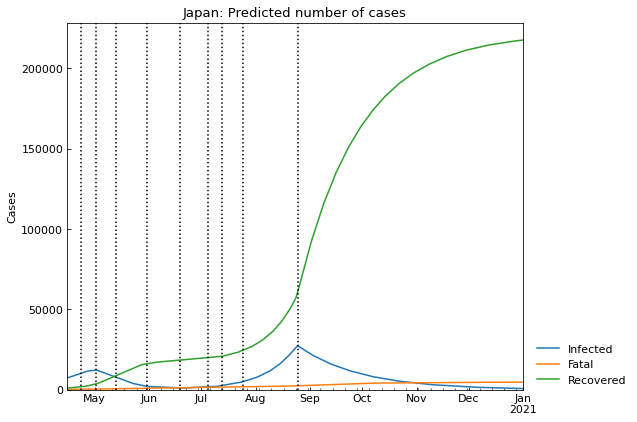

,Date,Fatal,Infected,Recovered,Susceptible
257,28Dec2020,4672,796,217166,126306466
258,29Dec2020,4673,774,217297,126306355
259,30Dec2020,4675,753,217425,126306247
260,31Dec2020,4677,732,217549,126306143
261,01Jan2021,4678,718,217630,126306075


In [38]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [39]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,10948900,01Jan2021,10948900,726250
Medicine,27360,25Aug2020,718,4678
